This file contains code to quantify differences in song structure and sequence based on sequence linearity, consistency and stereotypy [Sakata and Brainard 2006] and transition entropy [Scharff and Nottebohm 1991].

Date: 13/10/22

In [1]:
import math
import pandas
import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [33]:
#Function to find the indices of all the occurrence of 'End' in Syllable label
def find_end_indices(list, element):
    indices = [0]
    for idx, value in enumerate(list):
        if value == element:
            indices.append(idx)
    return indices

#Define a function to pick song bouts that are long in length - Returns a list of data frames
def motif_finder(bouts_list):
    song_w_motif = bouts_list.copy()
    syll_num = []
    short_song_idx = []
    for i in range(len(bouts_list)):
        bout = bouts_list[i]
        syllable_list = bout['Syll Label'].tolist()
        syll_num.append(len(syllable_list))
    avg_syl_num = np.mean(syll_num)
    for i in range(len(syll_num)):
        if syll_num[i] < avg_syl_num/3:
            short_song_idx.append(i)
    #as each index is deleted, the list shortens, so indices have to be updated
    for i in range(len(short_song_idx)):
        short_song_idx[i] -= i
    for j in short_song_idx:
        del song_w_motif[j]
    return song_w_motif

#Combines all the dataframes in a list
def concatenate_bout_list(bout_list):
    new_df = pandas.DataFrame()
    for i in range(len(bout_list)):
        new_df = pandas.concat([new_df, bout_list[i]])
    start_row = [0, 0, 'Start', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    new_df = pandas.DataFrame(np.insert(new_df.values, 0, start_row, axis=0))
    return new_df

#To extract mean value (from even-sized arrays only!)
def mean_value(data):
    avg = []
    for i in range(len(data[0])):
        temp = []
        for j in range(len(data)):
            t = data[j, i]
            temp.append(t)
        avg.append(np.mean(temp))
    return avg

#To calculate inter-note intervals
def intervals(song_list):
    intervals = []
    for i in range(len(song_list)):
        bout = song_list[i]
        in_int = []
        start = np.array(bout[' Syll Onset (ms)'])
        stop = np.array(bout[' Syll Offset (ms)'])
        for j in range(1, len(bout)):
            diff = start[j] - stop[j-1]
            in_int.append(diff)
        intervals.append(in_int)
    return intervals

In [19]:
data = {
    'Bird name' : [],
    'Species' : [],
    'No. of bouts' : [],
    'Avg. No. of Syll per song' : [],
    'Song duration' : [],
    'Avg. repeats of first syll' : [],
    'Minimum motif length' : []
}

df = pandas.DataFrame(data)
df.to_csv('syll_quantifiers.csv', index=False)

In [10]:
labels = ['BCC_M01', 'BCC_M03', 'JF_ylw22gry08']
sp_label = ['BCC', 'BCC', 'JF']

In [14]:
directory = 'D:\\4th Year\\Semester 7\\BI4313 Sem Project\\IN-comparative-analysis\\IN-comparative-analysis\\test\\Bouts_Start_End'

song_bout_files = []

# iterate over files in
# that directory
for filename in os.scandir(directory):
    if filename.is_file():
        song_bout_files.append(filename.path)

In [20]:

for file_idx in range(len(song_bout_files)):
    data = pandas.read_csv(song_bout_files[file_idx], header=None,
      names = ['FileName', 'Syll #', 'Syll Label',
      ' Syll Onset (ms)', ' Syll Offset (ms)', ' Syll Duration (sec)', ' Mean Frequency (Hz)',
      ' Entropy', 'Log Amplitude (dB)', 'Pitch Goodness', 'FrequencyModulation',
      'AmplitudeModulation', 'EntropyVariance', 'Fundamental Frequency (Hz)', 'RMS Amplitude'])

    syl = data['Syll Label']
    all_syl = syl.tolist()
    end_indices = find_end_indices(all_syl, 'End')

    song_bouts = []
    #This method of slicing includes 'Start' and 'End'
    for i in range(len(end_indices)-1):
        x = data.iloc[end_indices[i] + 2 : end_indices[i+1], :]
        song_bouts.append(x)

    song_motif = song_bouts

    #Number of bouts
    n_bouts = len(song_motif)

    #No. of syllables in a song
    syll_num = []
    for i in range(len(song_motif)):
        bout = song_motif[i]
        syllable_list = bout['Syll Label'].tolist()
        syll_num.append(len(syllable_list))
    avg_syl_num = int(np.mean(syll_num))
    #print(avg_syl_num)

    #Avg no. of times the first syllable repeats
    repeat_num = []
    for i in range(len(song_motif)):
        bout = song_motif[i]
        syllable_list = bout['Syll Label'].tolist()
        for t in range(1, len(syllable_list)):
            if syllable_list[t] != syllable_list[0]:
                first_syllable_repeats = t
                break
        repeat_num.append(first_syllable_repeats)
    avg_repeat_num = np.mean(repeat_num)

    #Song duration
    song_dur = []
    for i in range(len(song_motif)):
        bout = song_motif[i]
        onset = bout[' Syll Onset (ms)'].tolist()
        offset = bout[' Syll Offset (ms)'].tolist()
        t_start = float(onset[0])
        t_end = float(offset[len(bout)-1])
        diff = t_end - t_start
        dur = round(diff/1000, 2)
        song_dur.append(dur)
    avg_song_dur = np.mean(song_dur)

    mml = int(np.min(syll_num))

    data = {
    'Bird name' : [labels[file_idx]],
    'Species' : [sp_label[file_idx]],
    'No. of bouts' : [n_bouts],
    'Avg. No. of Syll per song' : [avg_syl_num],
    'Song duration' : [avg_song_dur],
    'Avg. repeats of first syll' : [avg_repeat_num],
    'Minimum motif length' : [mml]
    }

    df = pandas.DataFrame(data)
    df.to_csv('syll_quantifiers.csv', mode = 'a', index=False, header=False)

In [34]:
amp_data = {
    'Bird name' : [],
    'Species' : [],
    '#1' : [], '#2' : [], '#3' : [], '#4' : [], '#5' : [], '#6' : [], '#7' : [], '#8' : [], '#9' : [], '#10' : []
}
amp_df = pandas.DataFrame(amp_data)
amp_df.to_csv('Avg amplitude values.csv', index=False)


freq_data = {
    'Bird name' : [],
    'Species' : [],
    '#1' : [], '#2' : [], '#3' : [], '#4' : [], '#5' : [], '#6' : [], '#7' : [], '#8' : [], '#9' : [], '#10' : []
}
freq_df = pandas.DataFrame(freq_data)
freq_df.to_csv('Avg frequency values.csv', index=False)


dur_data = {
    'Bird name' : [],
    'Species' : [],
    '#1' : [], '#2' : [], '#3' : [], '#4' : [], '#5' : [], '#6' : [], '#7' : [], '#8' : [], '#9' : [], '#10' : []
}
dur_df = pandas.DataFrame(dur_data)
dur_df.to_csv('Avg syllable duration values.csv', index=False)


int_data = {
    'Bird name' : [],
    'Species' : [],
    '#1' : [], '#2' : [], '#3' : [], '#4' : [], '#5' : [], '#6' : [], '#7' : [], '#8' : [], '#9' : [], '#10' : []
}
int_df = pandas.DataFrame(int_data)
int_df.to_csv('Avg internote interval values.csv', index=False)

In [35]:
for file_idx in range(len(song_bout_files)):
    data = pandas.read_csv(song_bout_files[file_idx], header=None,
      names = ['FileName', 'Syll #', 'Syll Label',
      ' Syll Onset (ms)', ' Syll Offset (ms)', ' Syll Duration (sec)', ' Mean Frequency (Hz)',
      ' Entropy', 'Log Amplitude (dB)', 'Pitch Goodness', 'FrequencyModulation',
      'AmplitudeModulation', 'EntropyVariance', 'Fundamental Frequency (Hz)', 'RMS Amplitude'])

    syl = data['Syll Label']
    all_syl = syl.tolist()
    end_indices = find_end_indices(all_syl, 'End')

    song_bouts = []
    #This method of slicing includes 'Start' and 'End'
    for i in range(len(end_indices)-1):
        x = data.iloc[end_indices[i] + 2 : end_indices[i+1], :]
        song_bouts.append(x)

    song_motif = song_bouts

    syll_num = []
    for i in range(len(song_motif)):
        bout = song_motif[i]
        syllable_list = bout['Syll Label'].tolist()
        syll_num.append(len(syllable_list))
    
    #mml - minimum motif length (for which we'll plot the plots)
    mml = int(np.min(syll_num))
    #print(mml)
    if mml > 10:
        mml = 10
    #mml = 5

    #Average amplitude values
    amp = []
    for i in range(len(song_motif)):
        a = song_motif[i]['Log Amplitude (dB)']
        a = a.tolist()[:mml]
        amp.append(a)
    amp_10syl = np.array([np.array(i) for i in amp])
    avg_amp = mean_value(amp_10syl)
    amp_data = {'Bird name' : [labels[file_idx]], 'Species' : [sp_label[file_idx]], '#1' : [avg_amp[0]], '#2' : [avg_amp[1]], 
        '#3' : [avg_amp[2]], '#4' : [avg_amp[3]], '#5' : [avg_amp[4]], '#6' : [avg_amp[5]], '#7' : [avg_amp[6]], 
        '#8' : [avg_amp[7]], '#9' : [avg_amp[8]], '#10' : [avg_amp[9]]}
    amp_df = pandas.DataFrame(amp_data)
    amp_df.to_csv('Avg amplitude values.csv', mode='a', index=False, header=False)

    #Average frequency values
    frequency = []
    for i in range(len(song_motif)):
        f = song_motif[i][' Mean Frequency (Hz)']
        f = f.tolist()[:mml]
        frequency.append(f)
    freq_10syl = np.array([np.array(i) for i in frequency])
    avg_freq = mean_value(freq_10syl)
    freq_data = {'Bird name' : [labels[file_idx]], 'Species' : [sp_label[file_idx]], '#1' : [avg_freq[0]], '#2' : [avg_freq[1]], 
        '#3' : [avg_freq[2]], '#4' : [avg_freq[3]], '#5' : [avg_freq[4]], '#6' : [avg_freq[5]], '#7' : [avg_freq[6]], 
        '#8' : [avg_freq[7]], '#9' : [avg_freq[8]], '#10' : [avg_freq[9]]}
    freq_df = pandas.DataFrame(freq_data)
    freq_df.to_csv('Avg frequency values.csv', mode='a', index=False, header=False)

    #Average syllable duration values
    duration = []
    for i in range(len(song_motif)):
        d = song_motif[i][' Syll Duration (sec)']
        d = d.tolist()[:mml]
        duration.append(d)
    dur_10syl = np.array([np.array(i) for i in duration])
    avg_dur = mean_value(dur_10syl)
    dur_data = {'Bird name' : [labels[file_idx]], 'Species' : [sp_label[file_idx]], '#1' : [avg_dur[0]], '#2' : [avg_dur[1]], 
        '#3' : [avg_dur[2]], '#4' : [avg_dur[3]], '#5' : [avg_dur[4]], '#6' : [avg_dur[5]], '#7' : [avg_dur[6]], 
        '#8' : [avg_dur[7]], '#9' : [avg_dur[8]], '#10' : [avg_dur[9]]}
    dur_df = pandas.DataFrame(dur_data)
    dur_df.to_csv('Avg syllable duration values.csv', mode='a', index=False, header=False)

    #Average internote interval values
    internote_int = intervals(song_motif)
    int_all_syl = np.array([np.array(i) for i in internote_int])
    int_10syl = []
    for i in range(len(int_all_syl)):
        b = int_all_syl[i]
        b = b.tolist()[:mml]
        int_10syl.append(b)
    #int_10syl = np.array(int_10syl)
    int_10syl = np.array([np.array(i) for i in int_10syl])
    avg_int = mean_value(int_10syl)
    int_data = {'Bird name' : [labels[file_idx]], 'Species' : [sp_label[file_idx]], '#1' : [avg_int[0]], '#2' : [avg_int[1]], 
        '#3' : [avg_int[2]], '#4' : [avg_int[3]], '#5' : [avg_int[4]], '#6' : [avg_int[5]], '#7' : [avg_int[6]], 
        '#8' : [avg_int[7]], '#9' : [avg_int[8]], '#10' : [avg_int[9]]}
    int_df = pandas.DataFrame(int_data)
    int_df.to_csv('Avg internote interval values.csv', mode='a', index=False, header=False)

C:\Users\VASUDH~1\AppData\Local\Temp/ipykernel_12912/2148992954.py:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  int_all_syl = np.array([np.array(i) for i in internote_int])


To calculate differences in syllable types, and initial syllables, intersyllable interval, amplitude and so on. For that, we need to to go back to Onset-Offset data and chunk the song bouts using 'Start' and 'End'

1. Do the first syllables repeat in each song bout? 
2. Average number of syllables in each song bout

!! Make sure avg_syl/3 > 10 !!

In [33]:
#To calculate if the first syllable repeats, and if yes, how many times?
#Also get the number of syllables in each song

repeat_y_n = []
syll_num = []
syll_num_bouts = []

for i in range(len(song_motif)):
    bout = song_motif[i]
    syllable_list = bout['Syll Label'].tolist()
    syll_num.append(len(syllable_list))
    if len(syllable_list) > 3:
        if syllable_list[0] == syllable_list[1]:
            repeat_y_n.append(1)
        else:
            repeat_y_n.append(0)

for i in range(len(song_bouts)):
    bout = song_bouts[i]
    syllable_list = bout['Syll Label'].tolist()
    syll_num_bouts.append(len(syllable_list))

#mml - minimum motif length (for which we'll plot the plots)
mml = int(np.mean(syll_num_bouts)/3)
#mml = 8
print(mml)

print(sum(repeat_y_n), repeat_y_n, syll_num, len(syll_num))
print(f'Average number of syllables in a song bout: {np.mean(syll_num)}')
#print(f'Fraction of times the first syllable is repeated: {sum(repeat_y_n)/len(repeat_y_n)}')


4
14 [0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0] [14, 17, 13, 13, 17, 19, 10, 12, 12, 28, 15, 14, 14, 22, 17, 14, 18, 15, 13, 14, 13, 27, 9, 16, 17, 19, 14, 11, 11, 17, 14, 13] 32
Average number of syllables in a song bout: 15.375


Instead of counting the number of repeats in each song bout, we can also get the weighted average of self-transition probability of the starting syllables

In [35]:
#To find the average self-transition probability of the first syllables after start
syl_list = uniq_syl.tolist()
s = syl_list.index('Start')

def find_indices(list, element):
    indices = []
    for idx, value in enumerate(list):
        if value == element:
            indices.append(idx)
    return indices

first_syl = trans_num[s].tolist()
first_syl_idx = find_indices(first_syl, 1)

first_syl_trans = []
for i in first_syl_idx:
    first_syl_trans.append(trans_prob[i,i] * trans_prob[s,i])

print(first_syl_trans)
print(np.mean(first_syl_trans))

[0.24147618840204862, 0.050953948650312345, 0.20885089180593483, 0.2088934474475808]
0.17754361907646915


In [11]:
#Calculating inter-note interval

def intervals(song_list):
    intervals = []
    for i in range(len(song_list)):
        bout = song_list[i]
        in_int = []
        start = np.array(bout[' Syll Onset (ms)'])
        stop = np.array(bout[' Syll Offset (ms)'])
        for j in range(1, len(bout)):
            diff = start[j] - stop[j-1]
            in_int.append(diff)
        intervals.append(in_int)
    return intervals

internote_int = intervals(song_motif)


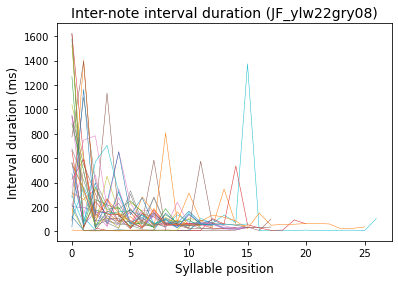

In [12]:
#To plot inter-not intervals

for i in range(len(internote_int)):
    y = internote_int[i]
    x = np.arange(len(y))
    plt.plot(x, y, linewidth = 0.5)

plt.xlabel('Syllable position', fontsize = 12)
plt.ylabel('Interval duration (ms)', fontsize = 12)
plt.title('Inter-note interval duration (JF_ylw22gry08)', fontsize = 14)

#plt.show()
plt.savefig('05 interval all syllables JF_ylw22gry08.png', dpi = 600)

C:\Users\VASUDH~1\AppData\Local\Temp/ipykernel_21092/3640815206.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  int_all_syl = np.array([np.array(i) for i in internote_int])


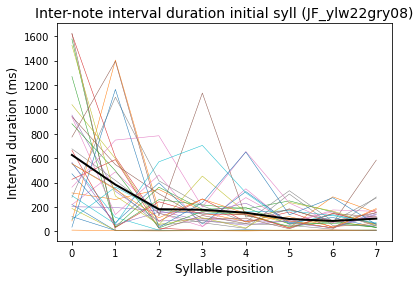

In [13]:
#To plot first 10 internote interval duration

int_all_syl = np.array([np.array(i) for i in internote_int])
int_10syl = []

for i in range(len(int_all_syl)):
    b = int_all_syl[i]
    b = b.tolist()
    b = b[:mml]
    int_10syl.append(b)

#int_10syl = np.array(int_10syl)
int_10syl = np.array([np.array(i) for i in int_10syl])

for i in range(len(internote_int)):
    y_temp = internote_int[i]
    y = y_temp[:mml]
    x = np.arange(len(y))
    plt.plot(x, y, linewidth = 0.5)

xaxis = np.arange(mml)
plt.plot(xaxis, mean_value(int_10syl), 'k', linewidth = 2)

plt.xlabel('Syllable position', fontsize = 12)
plt.ylabel('Interval duration (ms)', fontsize = 12)
plt.title('Inter-note interval duration initial syll (JF_ylw22gry08)', fontsize = 14)

#plt.show()
plt.savefig('06 interval syllables JF_ylw22gry08.png', dpi = 600)

Syllable mean frequency plots

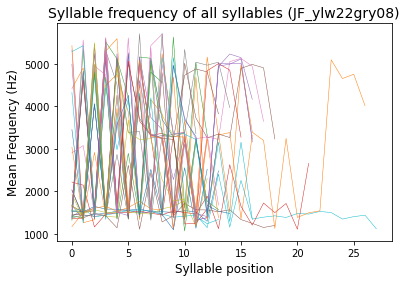

In [15]:
#Syllable frequency

for i in range(len(song_motif)):
    bout = song_motif[i]
    freq = bout[' Mean Frequency (Hz)']
    freq = freq.tolist()
    x = np.arange(len(bout))
    plt.plot(x, freq, linewidth = 0.5)


plt.xlabel('Syllable position', fontsize = 12)
plt.ylabel('Mean Frequency (Hz)', fontsize = 12)
plt.title('Syllable frequency of all syllables (JF_ylw22gry08)', fontsize = 14)

#plt.show()
plt.savefig('07 frequency all syllables JF_ylw22gry08.png', dpi = 600)

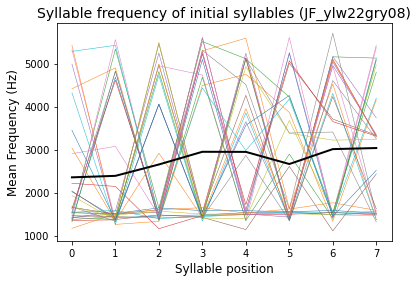

In [16]:
#Syllable mean frequency

frequency = []
for i in range(len(song_motif)):
    f = song_motif[i][' Mean Frequency (Hz)']
    f = f.tolist()[:mml]
    frequency.append(f)

freq_10syl = np.array([np.array(i) for i in frequency])

for i in range(len(song_motif)):
    bout = song_motif[i]
    freq = bout[' Mean Frequency (Hz)']
    freq = freq.tolist()[:mml]
    x = np.arange(mml)
    plt.plot(x, freq, linewidth = 0.5)

#plot the average values of first 10 syllables
xaxis = np.arange(mml)
plt.plot(xaxis, mean_value(freq_10syl), 'k', linewidth = 2)

plt.xlabel('Syllable position', fontsize = 12)
plt.ylabel('Mean Frequency (Hz)', fontsize = 12)
plt.title('Syllable frequency of initial syllables (JF_ylw22gry08)', fontsize = 14)

#plt.show()
plt.savefig('08 frequency init syllables JF_ylw22gry08.png', dpi = 600)